In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.ops import MLP
from tqdm.notebook import trange

* Write a validation step
* Experiment with `MLP` options
* Implement a CNN

Data: D.shape=(50000, 64, 64) Y.shape=(50000, 2)


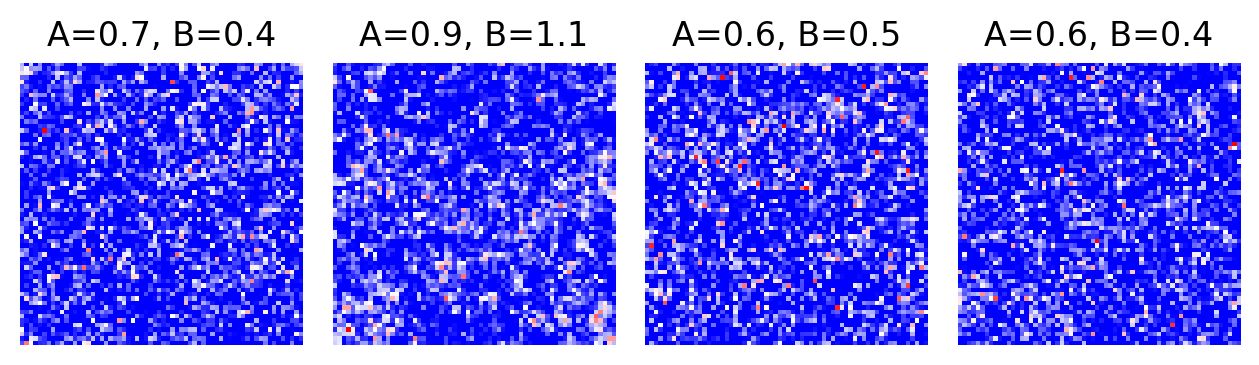

In [2]:
field_type = "gaussian" 
data_dir = "data/"

AB = np.array([1.0, 1.0])
lower = np.array([0.1, 0.1])
upper = np.array([2.0, 2.0])

D = np.load(data_dir + field_type + "_fields.npy")
Y = np.load(data_dir + field_type + "_fields_parameters.npy")

D0 = np.load(data_dir + field_type + "_fields_fiducial.npy")

covariance = np.load(data_dir + field_type + "_fields_covariance.npy")

print(f"Data: {D.shape=} {Y.shape=}")

fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(D[i], cmap="bwr")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [3]:
# a, b = D.min(), D.max()
# D = 2. * (D - a) / (b - a) - 1.
# D0 = 2. * (D0 - a) / (b - a) - 1.

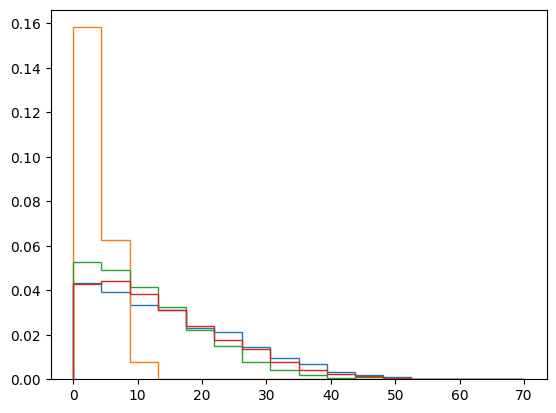

In [4]:
plt.figure()
for i in range(4):
    plt.hist(D[i].flatten(), bins=16, range=[0, 70], histtype="step", density=True)
plt.show()

In [5]:
# Data
data_dim = np.prod(D.shape[1:])
parameter_dim = Y.shape[-1]
# Model
H = [512, 512]
activation = nn.Tanh
# Optimisation
n_steps = 20_000
lr = 5e-4
batch_size = 400

In [6]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_parameters):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3, 1)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        # self.conv3 = nn.Conv2d(64, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, n_parameters)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x = self.conv3(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net(parameter_dim)
net(torch.ones((1, 1, 64, 64)))

tensor([[-0.8142, -0.5851]], grad_fn=<LogSoftmaxBackward0>)

In [7]:
def convert(x):
    # Convert numpy array to a torch tensor
    return torch.as_tensor(x).float()

def get_data(n):
    # Randomly select n elements from total datase
    ix = np.random.randint(len(D), size=(n,))
    return convert(D[ix])[:, None], convert(Y[ix])

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss_fn = nn.MSELoss()

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)
        
        loss = loss_fn(net(x), y)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses += [loss.item()]
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/20000 [00:00<?, ?it/s]

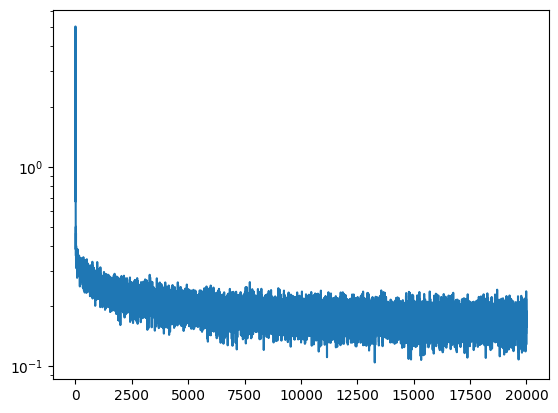

In [ ]:
plt.semilogy(losses)
plt.show()

In [ ]:
mean = D0.mean(axis=0).flatten()

data = np.random.multivariate_normal(mean, covariance)

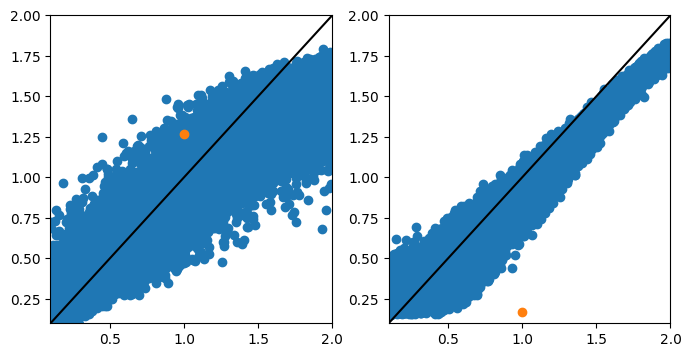

In [ ]:
net = net.eval()

def apply_net(x):
    # Convert a numpy array to a tensor and detach it
    return net(convert(x).flatten(1)).detach().numpy()

Y_data = apply_net(data[None, :]) 
Y_mean = apply_net(mean[None, :])
Y_ = apply_net(D)

fig, axs = plt.subplots(1, 2, figsize=(8., 4.))

ax = axs[0]
ax.scatter(Y[:, 0], Y_[:, 0])
ax.scatter(AB[0], Y_mean[:, 0])

ax.set_xlim(lower[0], upper[0])
ax.set_ylim(lower[0], upper[0])
ax.axline((0, 0), slope=1, color="k")

ax = axs[1]
ax.scatter(Y[:, 1], Y_[:, 1])
ax.scatter(AB[1], Y_mean[:, 1])

ax.set_xlim(lower[1], upper[1])
ax.set_ylim(lower[1], upper[1])
ax.axline((0, 0), slope=1, color="k")

plt.show()

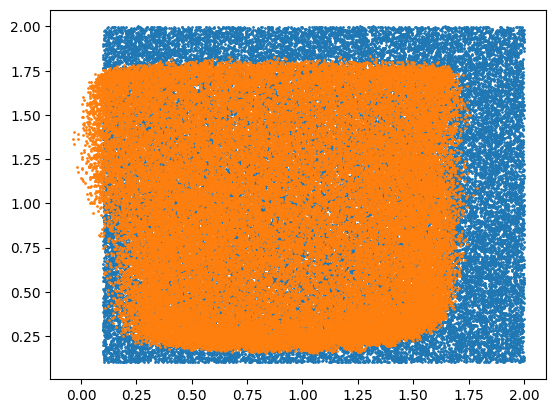

In [ ]:
plt.figure()
plt.scatter(*Y.T, s=1.)
plt.scatter(*Y_.T, s=1.)
# plt.scatter(*Y__.T, s=1.)
plt.show()

In [ ]:
# Save output summaries for simulations + data
np.save(os.path.join(data_dir, field_type + "_nn_summary_mean.npy"), Y_mean)
np.save(os.path.join(data_dir, field_type + "_nn_summary_data.npy"), Y_data)
np.save(os.path.join(data_dir, field_type + "_nn_summaries.npy"), Y_)